import libraries    


In [2]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from scipy.signal import butter, lfilter
from scipy import signal

defining functions

In [3]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    # print(a.size,"\n",b.size,"\n",y.size)
    return y

importing audio from data

In [4]:

audio_name = "sample_1.wav"
x, fs = librosa.load(os.getcwd()+"\\sample_data\\audio\\"+audio_name, sr=None)
print(fs)

#fs is the sample rate of the audio file

16000


Filtering audio

(94265,)
(94265,)


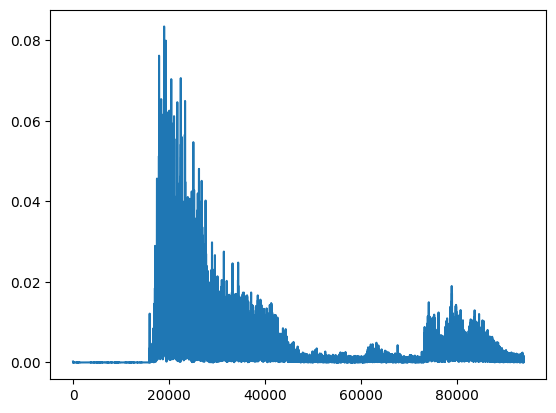

In [5]:
cutoff_low = 3000 # desired cutoff frequency of the filter, Hz
cutoff_high = 5000
order = 10

x_filt = butter_bandpass_filter(x,cutoff_low,cutoff_high,fs,order)
x_filt_hilbert = signal.hilbert(x_filt)
print(x_filt_hilbert.shape)
envelope_hat = np.abs(x_filt_hilbert)

#.
print(envelope_hat.shape)
y=np.linspace(0,94000,94000)
plt.plot(y,envelope_hat[0:94000])
plt.show()


filter the Hilbert envelope

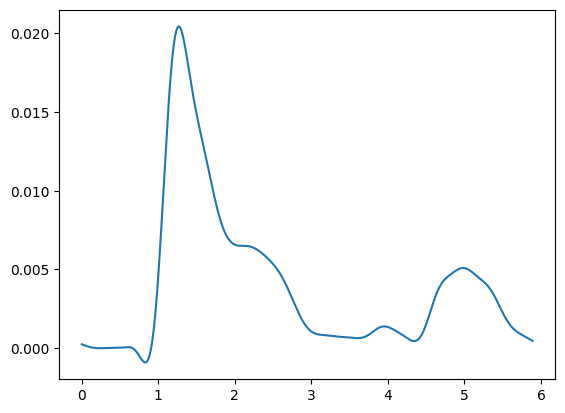

In [6]:
nyq_rate = fs /0.5
width = 1.0/nyq_rate # 5 Hz filter transition width.
ripple_db = 10.0 # stop band attenuation
fL_hz = 10
N, beta = signal.kaiserord(ripple_db, width)
taps = signal.firwin(N, fL_hz/nyq_rate, window=('kaiser', beta))
envelope_hat_filt = signal.filtfilt(taps, 1,envelope_hat)
t = np.arange(0,len(envelope_hat_filt))/fs

#.
plt.plot(t,envelope_hat_filt)

at this point we have the 
scale the envelope is estimate of flow rate. We will scale this to match actual flow range

In [7]:
envelope_hat_filt = np.interp(envelope_hat_filt, (envelope_hat_filt.min(), 1), (0, 8))
rPEF = round(envelope_hat_filt.max(),2)

estdVolume = np.cumsum(envelope_hat_filt)
estdVolume = np.interp(estdVolume, (0, np.cumsum([1]*len(t)).max()), (0, 8))

FEV1 Estimate

In [8]:
rFEV1 = round(estdVolume[np.where(t==1)[0][0]],2) 
print("rPEF: ",rPEF)       

rPEF:  0.17


FVC Estimate

In [9]:
rFVC = round(estdVolume[-1],2)
print("rFVC: ",rFVC)

rFVC:  0.31


FVC Ratio

In [10]:
rRatio = (rFEV1/rFVC)*100
print("rRatio: ",rRatio)

rRatio:  3.225806451612903


Plotting graphs

Text(0, 0.5, 'Estimated Flow')

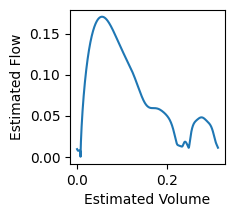

In [11]:
fig,ax = plt.subplots(1,1,figsize=(2,2))
ax.plot(estdVolume, envelope_hat_filt)
ax.set_xlabel('Estimated Volume')
ax.set_ylabel('Estimated Flow')